# 📌 Customer Segmentation Using Unsupervised Learning

### 🔹 Step 1: Load and Prepare the Data

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Loading excel file
file_path = "E-commerce_data.xlsx" 
xls = pd.ExcelFile(file_path)

print(xls.sheet_names)


['customers', 'genders', 'cities', 'transactions', 'branches', 'merchants']


In [103]:
# Load each sheet into a separate DataFrame
customers = pd.read_excel(xls, sheet_name="customers")
genders = pd.read_excel(xls, sheet_name="genders")
cities = pd.read_excel(xls, sheet_name="cities")
transactions = pd.read_excel(xls, sheet_name="transactions")
branches = pd.read_excel(xls, sheet_name="branches")
merchants = pd.read_excel(xls, sheet_name="merchants")


In [109]:
customers.head()

,customer_id,join_date,city_id,gender_id
0,1,2022-01-08,7,1
1,2,2023-05-02,20,2
2,3,2023-05-14,15,1
3,4,2022-11-25,11,2
4,5,2023-04-26,8,1


In [107]:
transactions.head()

,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id
0,1,733,2024-05-11,subscribed,uNY-568,NaT,7
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5
2,3,309,2022-11-13,subscribed,PLG-122,NaT,7
3,4,695,2024-01-26,subscribed,Wzf-897,NaT,2
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6


In [13]:
# Check data types for all columns
print(customers.info())
print(transactions.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  1000 non-null   int64         
 1   join_date    1000 non-null   datetime64[ns]
 2   city_id      1000 non-null   int64         
 3   gender_id    1000 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 31.4 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      5000 non-null   int64         
 1   customer_id         5000 non-null   int64         
 2   transaction_date    5000 non-null   datetime64[ns]
 3   transaction_status  5000 non-null   object        
 4   coupon_name         5000 non-null   object        
 5   burn_date           2516 non-null  

In [11]:
# Check for missing values in each table
for df_name, df in zip(["customers", "genders", "cities", "transactions", "branches", "merchants"],
                        [customers, genders, cities, transactions, branches, merchants]):
    print(f"{df_name} - Missing Values:\n{df.isnull().sum()}\n")


customers - Missing Values:
customer_id    0
join_date      0
city_id        0
gender_id      0
dtype: int64

genders - Missing Values:
gender_id      0
gender_name    0
dtype: int64

cities - Missing Values:
city_id      0
city_name    0
dtype: int64

transactions - Missing Values:
transaction_id           0
customer_id              0
transaction_date         0
transaction_status       0
coupon_name              0
burn_date             2484
branch_id                0
dtype: int64

branches - Missing Values:
branch_id      0
merchant_id    0
dtype: int64

merchants - Missing Values:
merchant_id      0
merchant_name    0
dtype: int64



In [111]:
import warnings
warnings.filterwarnings("ignore")


## Handling Missing Values

In [113]:
transactions['burn_date'].fillna("Not Burnt", inplace=True)


In [115]:
import numpy as np

# Check if any NaN values exist in the features dataframe
print(features.isnull().sum())

# Check if there are any NaN values after scaling
print(np.isnan(features_scaled).sum())


claimed_frequency    0
burn_frequency       0
burn_rate            0
dtype: int64
0


In [117]:
# Fill NaN values with 0 (Assuming missing values mean no claims)
features['claimed_frequency'].fillna(0, inplace=True)

# Standardize data again after fixing NaNs
features_scaled = scaler.fit_transform(features)


## Merging Tables

#### 1️⃣ Merge Customers with Genders & Cities


In [22]:
customers = customers.merge(genders, on="gender_id", how="left")
customers = customers.merge(cities, on="city_id", how="left")

#### 2️⃣ Merge Transactions with Customers

In [26]:
transactions = transactions.merge(customers, on="customer_id", how="left")

#### 3️⃣ Merge Transactions with Branches & Merchants

In [29]:
transactions = transactions.merge(branches, on="branch_id", how="left")
transactions = transactions.merge(merchants, on="merchant_id", how="left")

## Feature Engineering

#### 1️⃣ Creating Burn Frequency per Customer

In [33]:
burn_freq = transactions[transactions["burn_date"] != "Not Burnt"].groupby("customer_id")["transaction_id"].count().reset_index()
burn_freq.rename(columns={"transaction_id": "burn_frequency"}, inplace=True)

#### 2️⃣ Creating Claimed Frequency per Customer

In [36]:
claim_freq = transactions.groupby("customer_id")["transaction_id"].count().reset_index()
claim_freq.rename(columns={"transaction_id": "claimed_frequency"}, inplace=True)

#### 3️⃣ Merge These Features into Customers Table

In [119]:
customers = customers.merge(claim_freq, on="customer_id", how="left")
customers = customers.merge(burn_freq, on="customer_id", how="left")

# Fill NaN values (for customers who never burnt a coupon)
customers["burn_frequency"].fillna(0, inplace=True)


#### 4️⃣ Creating Burn Rate (Success Rate of Coupons)

In [121]:
customers["burn_rate"] = customers["burn_frequency"] / customers["claimed_frequency"]
customers["burn_rate"].fillna(0, inplace=True)  # Replace NaN with 0 (for customers who never claimed)

## Preparing Data for Clustering

In [49]:
#Select Features for Clustering
features = customers[['claimed_frequency', 'burn_frequency', 'burn_rate']]
# Normalize the Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


## Customer Segmentation with K-Means

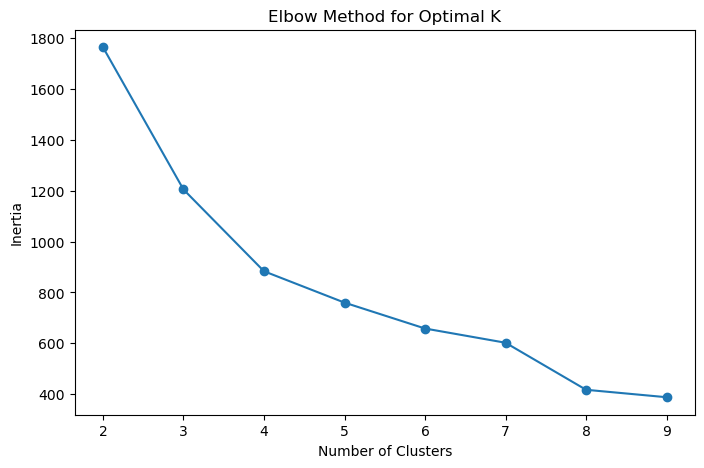

In [123]:
inertia = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()


In [76]:
print(features_scaled.shape)  # Expected: (1000, 3), but yours is (989, 3)
print(customers.shape)  # Expected: (1000, X)


(989, 3)
(1000, 11)


In [82]:
# Make sure features is a separate DataFrame
features = customers[['claimed_frequency', 'burn_frequency', 'burn_rate']].copy()

# Fill missing values to avoid dropping rows
features.fillna(0, inplace=True)

# Check if we now have all 1000 rows
print(features.shape)  # Should be (1000, 3)


(1000, 3)


In [84]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Verify the new shape
print(features_scaled.shape)  # Should be (1000, 3)


(1000, 3)


In [125]:
from sklearn.cluster import KMeans

k = 4  # Use the optimal number from the Elbow Method
kmeans = KMeans(n_clusters=k, random_state=42)

# Ensure the length of predictions matches the customers table
customers["cluster"] = kmeans.fit_predict(features_scaled)

# Check assigned clusters
print(customers["cluster"].value_counts())


cluster
3    352
1    245
0    211
2    192
Name: count, dtype: int64


## Evaluating Clusters
### 1️⃣ Silhouette Score

In [88]:
from sklearn.metrics import silhouette_score

silhouette = silhouette_score(features_scaled, customers["cluster"])
print(f"Silhouette Score: {silhouette:.4f}")


Silhouette Score: 0.3953


#### 2️⃣ Check Inertia (Within-Cluster Variance)

In [90]:
print(f"K-Means Inertia: {kmeans.inertia_}")


K-Means Inertia: 883.2807998781025


#### 3️⃣ Visualizing Cluster Distributions

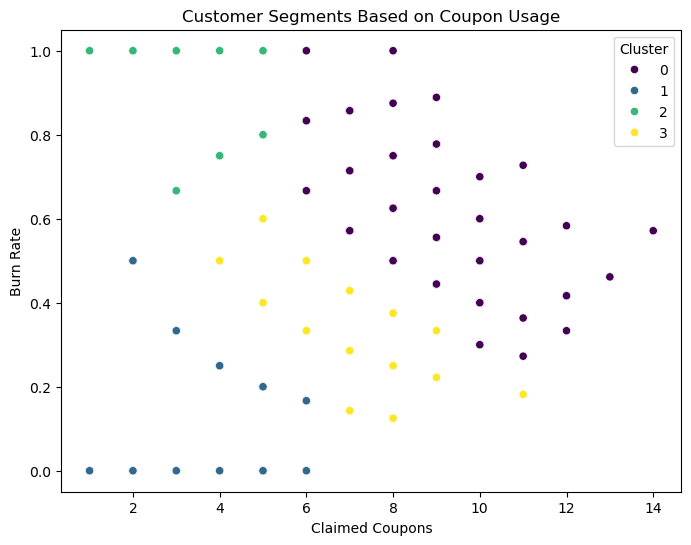

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=customers["claimed_frequency"], 
    y=customers["burn_rate"], 
    hue=customers["cluster"], 
    palette="viridis"
)
plt.title("Customer Segments Based on Coupon Usage")
plt.xlabel("Claimed Coupons")
plt.ylabel("Burn Rate")
plt.legend(title="Cluster")
plt.show()


## Analyzing Customer Segments

In [97]:
# Summary statistics per cluster
cluster_summary = customers.groupby("cluster")[["claimed_frequency", "burn_frequency", "burn_rate"]].mean()
print(cluster_summary)


         claimed_frequency  burn_frequency  burn_rate
cluster                                              
0                 7.815166        4.758294   0.625320
1                 3.128205        0.628571   0.209796
2                 3.276042        2.671875   0.838889
3                 5.653409        2.400568   0.440384


## Saving & Submitting the Project

In [100]:
# Save customers with cluster assignments
customers.to_csv("customer_segments.csv", index=False)
